# Titanic_Survival_Competition

In [24]:
#Library Imports: 

#DataFrame operation: 
import pandas as pd

#preproccecing: 
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [25]:
## Load Data: 
# here in titanic competion, we have two sets of Datas: train, test

df_train_path = '/home/vahid/Documents/ML_Learning/Titanic_Comp_kaggle/train.csv'
df_test_path = '/home/vahid/Documents/ML_Learning/Titanic_Comp_kaggle/test.csv'

df_train = pd.read_csv(df_train_path)
df_train.name = 'Training Set'
df_test = pd.read_csv(df_test_path)
df_test.name = 'Test Set'
df_data = pd.concat([df_train,df_test])
df_data.name = 'All Data'
print('train columns: ',df_train.columns,'\n')

# finding columns with missing values: 
def display_missing(df):
    for col in df.columns:
        print('({}): missing values: {}'.format(col, df[col].isnull().sum()))

for df in [df_train, df_test]:
    print('**Columns with Missing values of {}: '.format(df.name))
    display_missing(df)

train columns:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 

**Columns with Missing values of Training Set: 
(PassengerId): missing values: 0
(Survived): missing values: 0
(Pclass): missing values: 0
(Name): missing values: 0
(Sex): missing values: 0
(Age): missing values: 177
(SibSp): missing values: 0
(Parch): missing values: 0
(Ticket): missing values: 0
(Fare): missing values: 0
(Cabin): missing values: 687
(Embarked): missing values: 2
**Columns with Missing values of Test Set: 
(PassengerId): missing values: 0
(Pclass): missing values: 0
(Name): missing values: 0
(Sex): missing values: 0
(Age): missing values: 86
(SibSp): missing values: 0
(Parch): missing values: 0
(Ticket): missing values: 0
(Fare): missing values: 1
(Cabin): missing values: 327
(Embarked): missing values: 0


# Missing_Values

## Age: 
one of the important data here is the Age, and it has some missing values. 
How we refill these missing values is verey important. 

### replace missing values: 
I gess there is relationship between Title and Age. for example Capt dont refer to a child and so on. 
based on that my approach is: 
* extract titles from names. 
* classify titles. 
* group datas by title. 
* find median or mean of age based on grouped data. 
* fill the missing values by them. 

### Encoding: 

In [41]:
## Missing Values : Age

# Creating a new column called Title, 
# Extract the title from the name. 
for name_string in df_data['Name']: 
    df_data['Title'] = df_data['Name'].str.extract('([A-Za-z]+)\.',expand=True)

# Seeing All the titles we have. 
print('All Titles: \n',df_data['Title'].unique())

# Creat a temporary mapping dictionary: 
mapping = {'Dr':'Mr','Rev':'Mr','Mlle':'Miss','Major':'Mr','Col':'Mr',
          'Sir':'Mr','Don':'Mr','Mme':'Miss','Jonkheer':'Mr','Lady':'Mrs',
          'Capt':'Mr','Countess':'Mrs','Ms':'Miss','Dona':'Mrs',}
#replacing Titles with new title in mapping dictionary: 
#df_data.replace({'Title':mapping},inplace=True)

age_to_impute_median = df_data.groupby('Title')['Age'].median()
age_to_impute_mean = df_data.groupby('Title')['Age'].mean()

titles = ['Master', 'Miss', 'Mr', 'Mrs']
All_Titles = list(df_data['Title'].unique())
for title in All_Titles: 
    print(All_Titles.index(title), age_to_impute_median[All_Titles.index(title)])
    df_data.loc[(df_data['Age'].isnull()) & (df_data['Title'] == title), 'Age'] = age_to_impute_median[All_Titles.index(title)]
    
df_train['Age'] = df_data['Age'][:891]   
df_test['Age'] = df_data['Age'][891:]

# discard the title as we no longer need it: 
df_data.drop('Title', axis = 1, inplace=True)

#Binning Age
df_data['AgeBin'] = pd.qcut(df_data['Age'],5)
df_data['AgeBin'].head()

label = LabelEncoder()

df_data['AgeBin_Code'] = label.fit_transform(df_data['AgeBin'])
df_train['AgeBin_Code'] = df_data['AgeBin_Code'][:891]
df_test['AgeBin_Code'] = df_data['AgeBin_Code'][891:]

All Titles: 
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']
0 70.0
1 54.5
2 33.0
3 40.0
4 39.0
5 46.5
6 38.0
7 48.0
8 48.5
9 6.0
10 24.0
11 24.0
12 24.0
13 34.5
14 39.0
15 38.25
16 41.5
17 49.0


## Family Survived: 

in the DataFrame we have two columns named 'Parch' and 'SibSp' which refer to number of parent/children 
and number of siblings/spouse. so the Family Size is sum of these two. 

the idea is: there are relationships between each person and his/her family survived. 

the Approach is: 
* find family size for each person. 
* find each family members. 
** by seperating family name from the name of a person and group the data by family name, we can find each family members.
* find number of each family survived. 
* creat a column for these information. 
* make it one of the features. 

## 


In [43]:
df_data['Family_Size'] = df_data['Parch'] + df_data['SibSp']
df_train['Family_Size'] = df_data['Family_Size'][:891]
df_test['Family_Size'] = df_data['Family_Size'][891:]

df_data['Last_Name'] = df_data['Name'].apply(lambda x: str.split(x, ",")[0])

DEFAULT_SURVIVAL_VALUE = 0.5
df_data['Family_Survived'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in df_data[['Survived','Name', 'Last_Name', 'Fare',
                            'Ticket', 'PassengerId','Parch','SibSp',
                            'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    if (len(grp_df) != 1):
        for ind , row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data["PassengerId"] == passID, 'Family_Survived'] = 1
            elif (smin == 0.0):
                df_data.loc[df_data["PassengerId"] == passID, 'Family_Survived'] = 0
  
print("Number of Passengers with family survival data: ",
     df_data.loc[df_data['Family_Survived'] !=0.5].shape[0])
           
    
for grp ,grp_df in df_data.groupby('Ticket'): 
    if (len(grp_df) != 1):
        for ind , row in grp_df.iterrows():
            if (row['Family_Survived'] == 0 or row['Family_Survived'] == 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1): 
                    df_data.loc[df_data["PassengerId"] == passID, 'Family_Survived'] = 1
                elif (smin == 0.0):
                    df_data.loc[df_data["PassengerId"] == passID, 'Family_Survived'] = 0
                    
print("Number of Passengers with family/Group survival data: ",
     df_data.loc[df_data['Family_Survived'] !=0.5].shape[0])  

df_train['Family_Survived'] = df_data['Family_Survived'][:891]
df_test['Family_Survived'] = df_data['Family_Survived'][891:]

Number of Passengers with family survival data:  420
Number of Passengers with family/Group survival data:  546


## Fare Column: 

fare column consists of null values. besides that, range of values is wide and we need to encode values. 
so, at first we need to fill null values and then encoding values. 

for filling null values, the logical way may be using Pclass column. for that, group data by Pclass column and get the median of ech group. 
and then replace the missing values by that. 

after that, we need to encode velues. we can splite values to for example 5 interval and then attributiong a label to them. 

In [29]:
fare_to_impute = df_data.groupby('Pclass')['Fare'].median()
pclasses = [3,1,2]

for pcls in pclasses: 
    print(pclasses.index(pcls),fare_to_impute[pclasses.index(pcls)+1])
    df_data.loc[(df_data['Fare'].isnull()) & (df_data['Pclass'] == pcls), 'Fare'] = fare_to_impute[pclasses.index(pcls)+1]
    
    
df_data['FareBin'] = pd.qcut(df_data['Fare'],5)

label = LabelEncoder()
df_data['FareBin_Code'] = label.fit_transform(df_data['FareBin'])
df_train['FareBin_Code'] = df_data['FareBin_Code'][:891]
df_test['FareBin_Code'] = df_data['FareBin_Code'][891:]

0 60.0
1 15.0458
2 8.05


/tmp/ipykernel_7351/3178404276.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_train.drop(['Fare'], 1, inplace=True)
/tmp/ipykernel_7351/3178404276.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_test.drop(['Fare'], 1, inplace=True)


In [45]:
#mapping sex to code and then clean up any unnecessary stuff
df_train.Sex[(df_train['Age'] < 16) ] = 'Child'
df_test.Sex[(df_test['Age'] < 16)] = 'Child'
df_train.Sex.unique()
df_train['Sex'].replace(['male','female','Child'],[0,3,6],inplace=True)
df_test['Sex'].replace(['male','female','Child'],[0,3,6],inplace =True)

df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Family_Size,Family_Survived,FareBin_Code,AgeBin_Code
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,NaN,S,1,0.5,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",3,38.0,1,0,PC 17599,C85,C,1,0.5,4,3
2,3,1,3,"Heikkinen, Miss. Laina",3,26.0,0,0,STON/O2. 3101282,NaN,S,0,0.5,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",3,35.0,1,0,113803,C123,S,1,0.0,4,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,NaN,S,0,0.5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,NaN,S,0,0.5,2,1
887,888,1,1,"Graham, Miss. Margaret Edith",3,19.0,0,0,112053,B42,S,0,0.5,3,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",3,33.0,1,2,W./C. 6607,NaN,S,3,0.0,3,2
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,C148,C,0,0.5,3,1


In [ ]:
## Dropping unneccessary columns: 

#Discard the raw fare data as it is no longer useful
df_train.drop(['Fare'], 1, inplace=True)
df_test.drop(['Fare'], 1, inplace=True)

#Drop the original age feature from the dataset
df_train.drop(['Age'], 1, inplace=True)
df_test.drop(['Age'], 1, inplace=True)

#dropping a whole bunch of unused featureds
df_train.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
df_test.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)
train_df.columns
train_df.head()

In [4]:
# finding columns with missing values: 
def display_missing(df):
    for col in df.columns:
        print('({}): missing values: {}'.format(col, df[col].isnull().sum()))

for df in [df_train, df_test]:
    print('**Columns with Missing values of {}: '.format(df.name))
    display_missing(df)

**Columns with Missing values of Training Set: 
(PassengerId): missing values: 0
(Survived): missing values: 0
(Pclass): missing values: 0
(Name): missing values: 0
(Sex): missing values: 0
(Age): missing values: 0
(SibSp): missing values: 0
(Parch): missing values: 0
(Ticket): missing values: 0
(Fare): missing values: 0
(Cabin): missing values: 687
(Embarked): missing values: 2
**Columns with Missing values of Test Set: 
(PassengerId): missing values: 0
(Pclass): missing values: 0
(Name): missing values: 0
(Sex): missing values: 0
(Age): missing values: 0
(SibSp): missing values: 0
(Parch): missing values: 0
(Ticket): missing values: 0
(Fare): missing values: 1
(Cabin): missing values: 327
(Embarked): missing values: 0


In [5]:
#obtaining target(dependent variable) and predictors(independent variable): 
y = df_train.Survived
features_1 = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
features_2 = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',]
features_3 = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']

X = df_train[features_2].copy()
X_test = df_test[features_2].copy()

In [6]:
## make Sex column numerical. 

temp_Sex_X = pd.get_dummies(X['Sex'])
X['Sex_F'] = temp_Sex_X['female']
X['Sex_M'] = temp_Sex_X['male']
X.drop('Sex',inplace=True, axis=1)

temp_Sex_X_test = pd.get_dummies(X_test['Sex'])
X_test['Sex_F'] = temp_Sex_X_test['female']
X_test['Sex_M'] = temp_Sex_X_test['male']
X_test.drop('Sex',inplace=True, axis=1)

In [7]:
## Missing values: 

# here, for missing values I used simpleImputer:
# Imputer for train datas: 
my_imputer = SimpleImputer()

imputed_X = pd.DataFrame(my_imputer.fit_transform(X))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

# Imputation removed column names; put them back: 
imputed_X.columns = X.columns
imputed_X_test.columns = X_test.columns

In [8]:
## I have sets of data that are continiuous and make prediction continuous. 
## I want to put them in specified classes tp avoid this problem. 


X_ImpConv = imputed_X.copy()
X_test_ImpConv = imputed_X_test.copy()

# defining a function for classifing data:
def my_converter(data_series, num_clas):
    first_list = list(data_series)
    conved_list = list()
    len_clas = (max(first_list) - min(first_list))/num_clas
    for i in range(len(first_list)): 
        botm_bound = 0
        uper_bound = len_clas
        for k in range(num_clas+1): 
            if first_list[i] >= botm_bound and first_list[i] < uper_bound:
                conved_list.append(k)
                break
            else: 
                botm_bound = botm_bound + len_clas
                uper_bound = uper_bound + len_clas
    return conved_list
                
    
## for Age and Fare I want to use this converter to classifying them.    
# defining new columns named conv_Age and conv_Fare. 
X_ImpConv['conv_Age'] = my_converter(imputed_X.Age,20)
X_ImpConv['conv_Fare'] = my_converter(imputed_X.Fare,20)

X_test_ImpConv['conv_Age'] = my_converter(imputed_X_test.Age,20)
X_test_ImpConv['conv_Fare'] = my_converter(imputed_X_test.Fare,20)

# dropping the original columns for Age and Fare. 
X_ImpConv.drop('Age',inplace=True, axis=1)
X_ImpConv.drop('Fare',inplace=True, axis=1)

X_test_ImpConv.drop('Age',inplace=True, axis=1)
X_test_ImpConv.drop('Fare',inplace=True, axis=1)


X_test_ImpConv.head()

,Pclass,SibSp,Parch,Sex_F,Sex_M,conv_Age,conv_Fare
0,3.0,0.0,0.0,0.0,1.0,9,0
1,3.0,1.0,0.0,1.0,0.0,12,0
2,2.0,0.0,0.0,0.0,1.0,16,0
3,3.0,0.0,0.0,0.0,1.0,7,0
4,3.0,1.0,1.0,1.0,0.0,5,0


## Feature Engineering

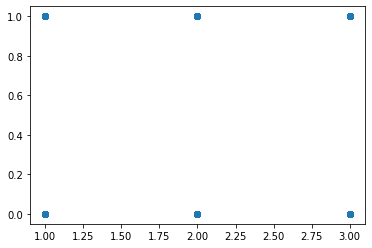

number of unique values of Pclass column:  3
unique values of Pclass column:  [3, 1, 2]
% of Pclass_1 who survived: 0.6296296296296297
% of Pclass_2 who survived: 0.47282608695652173
% of Pclass_3 who survived: 0.24236252545824846


In [51]:
## I want to know if Pclass is the good feature to consider??
    
plt.scatter(df_train.Pclass, y)
plt.show()

print("number of unique values of Pclass column: ",df_train.Pclass.nunique())
print("unique values of Pclass column: ",list(df_train.Pclass.unique()))

Pclass_1 = df_train.loc[df_train.Pclass == 1]["Survived"]
rate_Pclass_1 = sum(Pclass_1)/len(Pclass_1)
print("% of Pclass_1 who survived:", rate_Pclass_1)

Pclass_2 = df_train.loc[df_train.Pclass == 2]["Survived"]
rate_Pclass_2 = sum(Pclass_2)/len(Pclass_2)
print("% of Pclass_2 who survived:", rate_Pclass_2)

Pclass_3 = df_train.loc[df_train.Pclass == 3]["Survived"]
rate_Pclass_3 = sum(Pclass_3)/len(Pclass_3)
print("% of Pclass_3 who survived:", rate_Pclass_3)

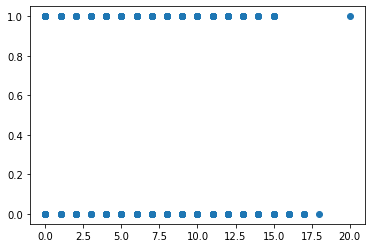

number of unique values of Age_class column:  20
unique values of Age_class column:  [5, 9, 6, 8, 7, 13, 0, 3, 1, 14, 2, 4, 10, 16, 12, 11, 17, 15, 20, 18]
% of Age_clas_1 who survived: 1.0


1

In [120]:
## I want to know if Age is the good feature to consider??

temp_X_ImpConv = X_ImpConv.copy()
temp_X_ImpConv["Survived"] = y


import matplotlib.pyplot as plt
    
plt.scatter(temp_X_ImpConv.conv_Age, y)
plt.show()


print("number of unique values of Age_class column: ",temp_X_ImpConv.conv_Age.nunique())
print("unique values of Age_class column: ",list(temp_X_ImpConv.conv_Age.unique()))

Age_clas_1 = temp_X_ImpConv.loc[temp_X_ImpConv.conv_Age == 20]["Survived"]
rate_Age_clas_1 = sum(Age_clas_1)/len(Age_clas_1)
print("% of Age_clas_1 who survived:", rate_Age_clas_1)
len(Age_clas_1)

In [142]:
print("number of unique values of SibSp column: ",df_train.SibSp.nunique())
print("unique values of SibSp column: ",list(df_train.SibSp.unique()))

for i in range(len(df_train.SibSp.unique())): 
    SibSp = df_train.loc[df_train.SibSp == df_train.SibSp.unique()[i]]["Survived"]
    rate_SibSp = sum(SibSp)/len(SibSp)
    print("percentage of %d member of SibSp %d who survived: %f: " % (len(SibSp),df_train.SibSp.unique()[i],rate_SibSp)) 

number of unique values of SibSp column:  7
unique values of SibSp column:  [1, 0, 3, 4, 2, 5, 8]
percentage of 209 member of SibSp 1 who survived: 0.535885: 
percentage of 608 member of SibSp 0 who survived: 0.345395: 
percentage of 16 member of SibSp 3 who survived: 0.250000: 
percentage of 18 member of SibSp 4 who survived: 0.166667: 
percentage of 28 member of SibSp 2 who survived: 0.464286: 
percentage of 5 member of SibSp 5 who survived: 0.000000: 
percentage of 7 member of SibSp 8 who survived: 0.000000: 


In [143]:
print("number of unique values of Parch column: ",df_train.Parch.nunique())
print("unique values of Parch column: ",list(df_train.Parch.unique()))

for i in range(len(df_train.Parch.unique())): 
    Parch = df_train.loc[df_train.Parch == df_train.Parch.unique()[i]]["Survived"]
    rate_Parch = sum(Parch)/len(Parch)
    print("percentage of %d member of Parch %d who survived: %f: " % (len(Parch),df_train.Parch.unique()[i],rate_Parch))    

number of unique values of Parch column:  7
unique values of Parch column:  [0, 1, 2, 5, 3, 4, 6]
percentage of 678 member of Parch 0 who survived: 0.343658: 
percentage of 118 member of Parch 1 who survived: 0.550847: 
percentage of 80 member of Parch 2 who survived: 0.500000: 
percentage of 5 member of Parch 5 who survived: 0.200000: 
percentage of 5 member of Parch 3 who survived: 0.600000: 
percentage of 4 member of Parch 4 who survived: 0.000000: 
percentage of 1 member of Parch 6 who survived: 0.000000: 


In [146]:
temp_X_ImpConv = X_ImpConv.copy()
temp_X_ImpConv["Survived"] = y

print("number of unique values of conv_Fare column: ",temp_X_ImpConv.conv_Fare.nunique())
print("unique values of conv_Fare column: ",list(temp_X_ImpConv.conv_Fare.unique()))

for i in range(len(temp_X_ImpConv.conv_Fare.unique())): 
    conv_Fare = temp_X_ImpConv.loc[temp_X_ImpConv.conv_Fare == temp_X_ImpConv.conv_Fare.unique()[i]]["Survived"]
    rate_conv_Fare = sum(conv_Fare)/len(conv_Fare)
    print("percentage of %d member of SibSp %d who survived: %f: " % (len(conv_Fare),temp_X_ImpConv.conv_Fare.unique()[i],rate_conv_Fare)) 

number of unique values of conv_Fare column:  11
unique values of conv_Fare column:  [0, 2, 1, 10, 5, 3, 9, 4, 19, 6, 8]
percentage of 562 member of SibSp 0 who survived: 0.284698: 
percentage of 67 member of SibSp 2 who survived: 0.597015: 
percentage of 170 member of SibSp 1 who survived: 0.429412: 
percentage of 6 member of SibSp 10 who survived: 0.666667: 
percentage of 16 member of SibSp 5 who survived: 0.750000: 
percentage of 39 member of SibSp 3 who survived: 0.769231: 
percentage of 2 member of SibSp 9 who survived: 0.500000: 
percentage of 15 member of SibSp 4 who survived: 0.733333: 
percentage of 3 member of SibSp 19 who survived: 1.000000: 
percentage of 2 member of SibSp 6 who survived: 1.000000: 
percentage of 9 member of SibSp 8 who survived: 0.666667: 


In [ ]:
X = pd.get_dummies(X[])
X_test = pd.get_dummies(test_data[features])